In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from catboost import Pool
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import pandas as pd


C:\Users\ADM\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = "Dropout_Academic Success - Sheet1.csv"

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "ankanhore545/dropout-or-academic-success",
  file_path,
)

C:\Users\ADM\AppData\Local\Temp\ipykernel_7908\2961937467.py:3: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


In [3]:
X = df.drop(columns=['Target'])
y = df['Target']

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # Padronizando os recursos

In [5]:
model = CatBoostClassifier(
    loss_function="MultiClass",
    eval_metric="TotalF1",          # ou "MultiClass"
    random_seed=42,
    auto_class_weights="Balanced",  # balanceamento automático
    border_count=252,
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    early_stopping_rounds=50,
    verbose=100
)


In [6]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

In [8]:
train_pool = Pool(
    X_train,
    y_train,
    feature_names=list(X_train.columns)
)

val_pool = Pool(
    X_val,
    y_val,
    feature_names=list(X_val.columns)
)

In [9]:
model.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True
)

0:	learn: 0.6768966	test: 0.5998542	best: 0.5998542 (0)	total: 161ms	remaining: 2m 41s
100:	learn: 0.7866896	test: 0.7084671	best: 0.7145289 (82)	total: 1.36s	remaining: 12.1s
200:	learn: 0.8538325	test: 0.7199738	best: 0.7201986 (163)	total: 2.58s	remaining: 10.3s
300:	learn: 0.9054933	test: 0.7198211	best: 0.7241992 (262)	total: 4.01s	remaining: 9.31s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7241992244
bestIteration = 262

Shrink model to first 263 iterations.


In [10]:
y_pred = model.predict(X_val)

In [11]:
y_proba = model.predict_proba(X_val)

DROPOUT_CLASS = 0  # Dropout

dropout_probs = y_proba[:, DROPOUT_CLASS]

threshold = 0.30 #"Se a probabilidade de Dropout for maior que 30%, então classifique como Dropout, mesmo que outra classe tenha probabilidade maior."

y_pred_thresh = np.argmax(y_proba, axis=1)
y_pred_thresh[dropout_probs >= threshold] = DROPOUT_CLASS

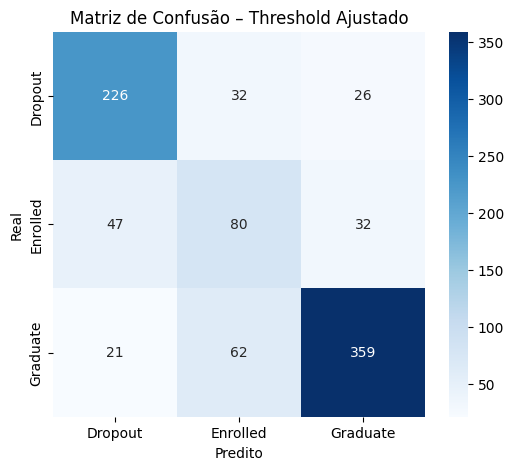

In [12]:
cm = confusion_matrix(y_val, y_pred_thresh)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão – Threshold Ajustado")
plt.show()

In [13]:
feature_importance = model.get_feature_importance(
    type="PredictionValuesChange"
)

feat_imp = pd.Series(
    feature_importance,
    index=X_train.columns
).sort_values(ascending=False)

print("🔝 Importância das features (CatBoost):")
print(feat_imp.head(15))


🔝 Importância das features (CatBoost):
Curricular units 2nd sem (approved)       16.874505
Curricular units 2nd sem (grade)           5.943875
Course                                     5.534239
Curricular units 1st sem (approved)        5.401523
Curricular units 2nd sem (evaluations)     4.817126
Tuition fees up to date                    4.762957
Admission grade                            4.247810
Age at enrollment                          3.915147
Previous qualification (grade)             3.398835
Curricular units 1st sem (evaluations)     3.339577
Curricular units 1st sem (grade)           3.257983
Mother's occupation                        3.222393
Application mode                           3.165716
Father's qualification                     3.123308
GDP                                        2.938013
dtype: float64


A análise de importância das variáveis foi realizada utilizando o método PredictionValuesChange do CatBoost, com o objetivo de interpretar o comportamento do modelo, validar o aprendizado e identificar atributos mais relevantes para a predição de evasão (Dropout). Essa etapa foi fundamental para garantir confiabilidade, reduzir ruído e orientar ajustes posteriores no modelo.